### Monte Carlo Localization
Made by Oleg Borisov

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
np.random.seed(0)

In [2]:
def mktr(x, y):
    return np.array([[1, 0, x],
                     [0, 1, y],
                     [0, 0, 1]])


def mkrot(theta):
    return np.array([[np.cos(theta), -np.sin(theta), 0],
                     [np.sin(theta),  np.cos(theta), 0],
                     [0,              0,             1]])

In [3]:
def ddtr(vl, vr, l, dt):
    """ returns the pose transform for a motion with duration dt of a differential
    drive robot with wheel speeds vl and vr and wheelbase l """

    if(np.isclose(vl, vr)):  # we are moving straight, R is at the infinity and we handle this case separately
        return mktr((vr + vl)/2*dt, 0)  # note we translate along x ()

    omega = (vr - vl) / (2 * l)  # angular speed of the robot frame
    R = l * (vr + vl) / (vr - vl)
#     print (R)

    # Make sure you understand this!
    return mktr(0, R) @ mkrot(omega * dt) @ mktr(0, -R)

That is all what we need from the previously studied material

In [4]:
### Some global variables that could be changed

# noise to be added
absolute_noise = 0.05

# samples for position approximation 
samples_number = 400

# how often do we take a measurment
delta_t = 1 # i.e. every second

# lenght between the wheels of DDR
l = 1

start_pose = mkrot(0) @ mktr(0, 0)

In [5]:
# function that will generate the sample point from given the current pose

def move(vl, vr, curr_pose):
    # add noise to the wheel speed
    vl_noisy = vl + np.random.uniform(-absolute_noise,absolute_noise)
    vr_noisy = vr + np.random.uniform(-absolute_noise,absolute_noise)
    
    # calculate the relative transformation with the current values
    movement = ddtr(vl_noisy, vr_noisy, l, delta_t)
    
    # return the current pose of DDR
    return curr_pose @ movement 

In [6]:
# Check if we can extract position
pose_experiment = move(5,5, start_pose)
pose_experiment[:2,2]

array([5.01314232, 0.02085177])

In order to simplify our life, let me introduce two supporting functions:


- `update_samples`: which is going to calculate the position belief for the non-sensing robot based on the previous stage of position estimates and on the robot's true `vl` and `vr` velocities. This function will append the estimates generated from the new stage to the estimate poses history list

- `exact_trajectory`: function that is going to draw the True location and the True motion of the DDR

In [7]:
# "The new sample’s l is then generated by generating a single, 
# random sample from P(l | l',a), using the action a as observed"
# *Taken from "Monte Carlo Localization: Efficient Position Estimation for Mobile Robots" paper

# since we dont have any observations in this model, we pick the 
# generated pose randomly

def update_samples(vl, vr, poses):
    # new poses that we calculate
    new_poses = []
    
    # previous poses estimations
    latest_poses = poses[-1]
    
    for _ in range(len(latest_poses)):
        # pick a sample index randomly from the previous estimates
        candidate_pose_index = np.random.randint(0,len(latest_poses))
        
        # pick a sample given the index
        candidate_pose = latest_poses[candidate_pose_index]
        
        # estimate the new pose of the current sample
        sample = move(vl,vr, candidate_pose)
        
        # save new pose 
        new_poses.append(sample)
    
    # add new estimations to the pose history estimatioin list
    poses.append(new_poses)
    return poses

In [8]:
# Function requires to have the history of all the velocities of the robot, 
# in order to generate the exact path

def exact_trajectory(vl_hist,vr_hist,start_pose, n_eval = 100):

    # store the exact x,y coordinates of the robot
    actual_trajectory_x = []
    actual_trajectory_y = []
    
    # ideal pose is the original pose
    pose_ideal = start_pose
    
    # in order to have a good drawing precision we want to make
    # many measurments in between pose p_k and p_{k+1}
    # therefore, find t such that we equally subdivide delta_t by
    # n_eval equal pieces
    
    t = delta_t/n_eval
    
    # go through all different speeds of the robot
    for i in range(len(vl_hist)):
        
        # and estimate the correct path for the interval
        for _ in np.linspace(0, delta_t, n_eval):
            
            # calculate the ideal pose updated
            pose_ideal = pose_ideal @ ddtr(vl_hist[i], vr_hist[i], l, t)
            
            # store x and y coordinates
            actual_trajectory_x.append(pose_ideal[:2,2][0])
            actual_trajectory_y.append(pose_ideal[:2,2][1])
            
        plot_the_sample(pose_ideal, case="actual")
    
    plt.plot(actual_trajectory_x,actual_trajectory_y, 'b')  

Also let's make some plotting functions that will visualize the all estimates

In [9]:
# Plot one sample/robot given its pose

# this function if used for both, sample plotting and the actual robot pose plotting
# therefore we need to use "case"  
def plot_the_sample(pose, case = "estimate"): 
    # marker = triangle_right
    robot = matplotlib.markers.MarkerStyle(marker='>')
    
    # marker = tickright
    direction = matplotlib.markers.MarkerStyle(marker=1)
    
    # for the orientation of the robot we need to take a look at the rotation matrix 
    # and find arctan of the elements of the first column (by the construction of 2d rotation matrix)
    cos = pose[0,0]
    sin = pose[1,0]
    
    # find arctan and translate from radians to degrees to
    angle = np.degrees(np.arctan2(sin,cos))
    
    # orient our robot and its heading markers according to the angle of the sample
    robot._transform = robot.get_transform().rotate_deg(angle)
    direction._transform = direction.get_transform().rotate_deg(angle)
    
    # default values
    c1, c2 = 'r','g'
    alp1, alp2 = 0.2, 0.5
    
    # for the case if we work with exact values
    if case != "estimate":
        c1, c2 = 'gold','gold'
        alp1, alp2 = 0.8, 0.8

    # plot the robot
    plt.scatter(pose[:2,2][0], pose[:2,2][1], c=c1 ,marker=robot, s = 1000, alpha = alp1)
    #plot the marker
    plt.scatter(pose[:2,2][0], pose[:2,2][1], c=c2 ,marker=direction, s = 1000, alpha = alp2)

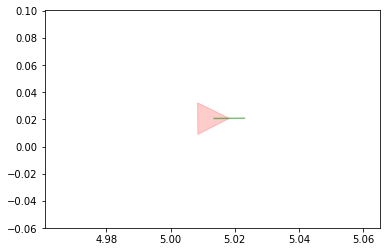

In [10]:
# Visualization of the representation of the sample
# recall that pose_experiment contains the estimate of the robot moving forward with the
# speeds of vl = vr = 5

plot_the_sample(pose_experiment)

The robot is represented by the triangle and the tick that point into the direction of the orientation of our robot
Since we will have a large number of samples we need to introduce some transparancy of the robot
The size is small, because later we will use many different estimates of the robot pose therefore having smaller size will give us better info about all the estimates 

In [11]:
#  plot all the estimates from all the stages of estimation
def plot_all_estimates(all_poses):
    
    # all poses of different steps/stages of estimation
    for stage_poses in all_poses:
        
        # all poses of particular step
        for pose in stage_poses:
            plot_the_sample(pose)
    plt.axis("equal")

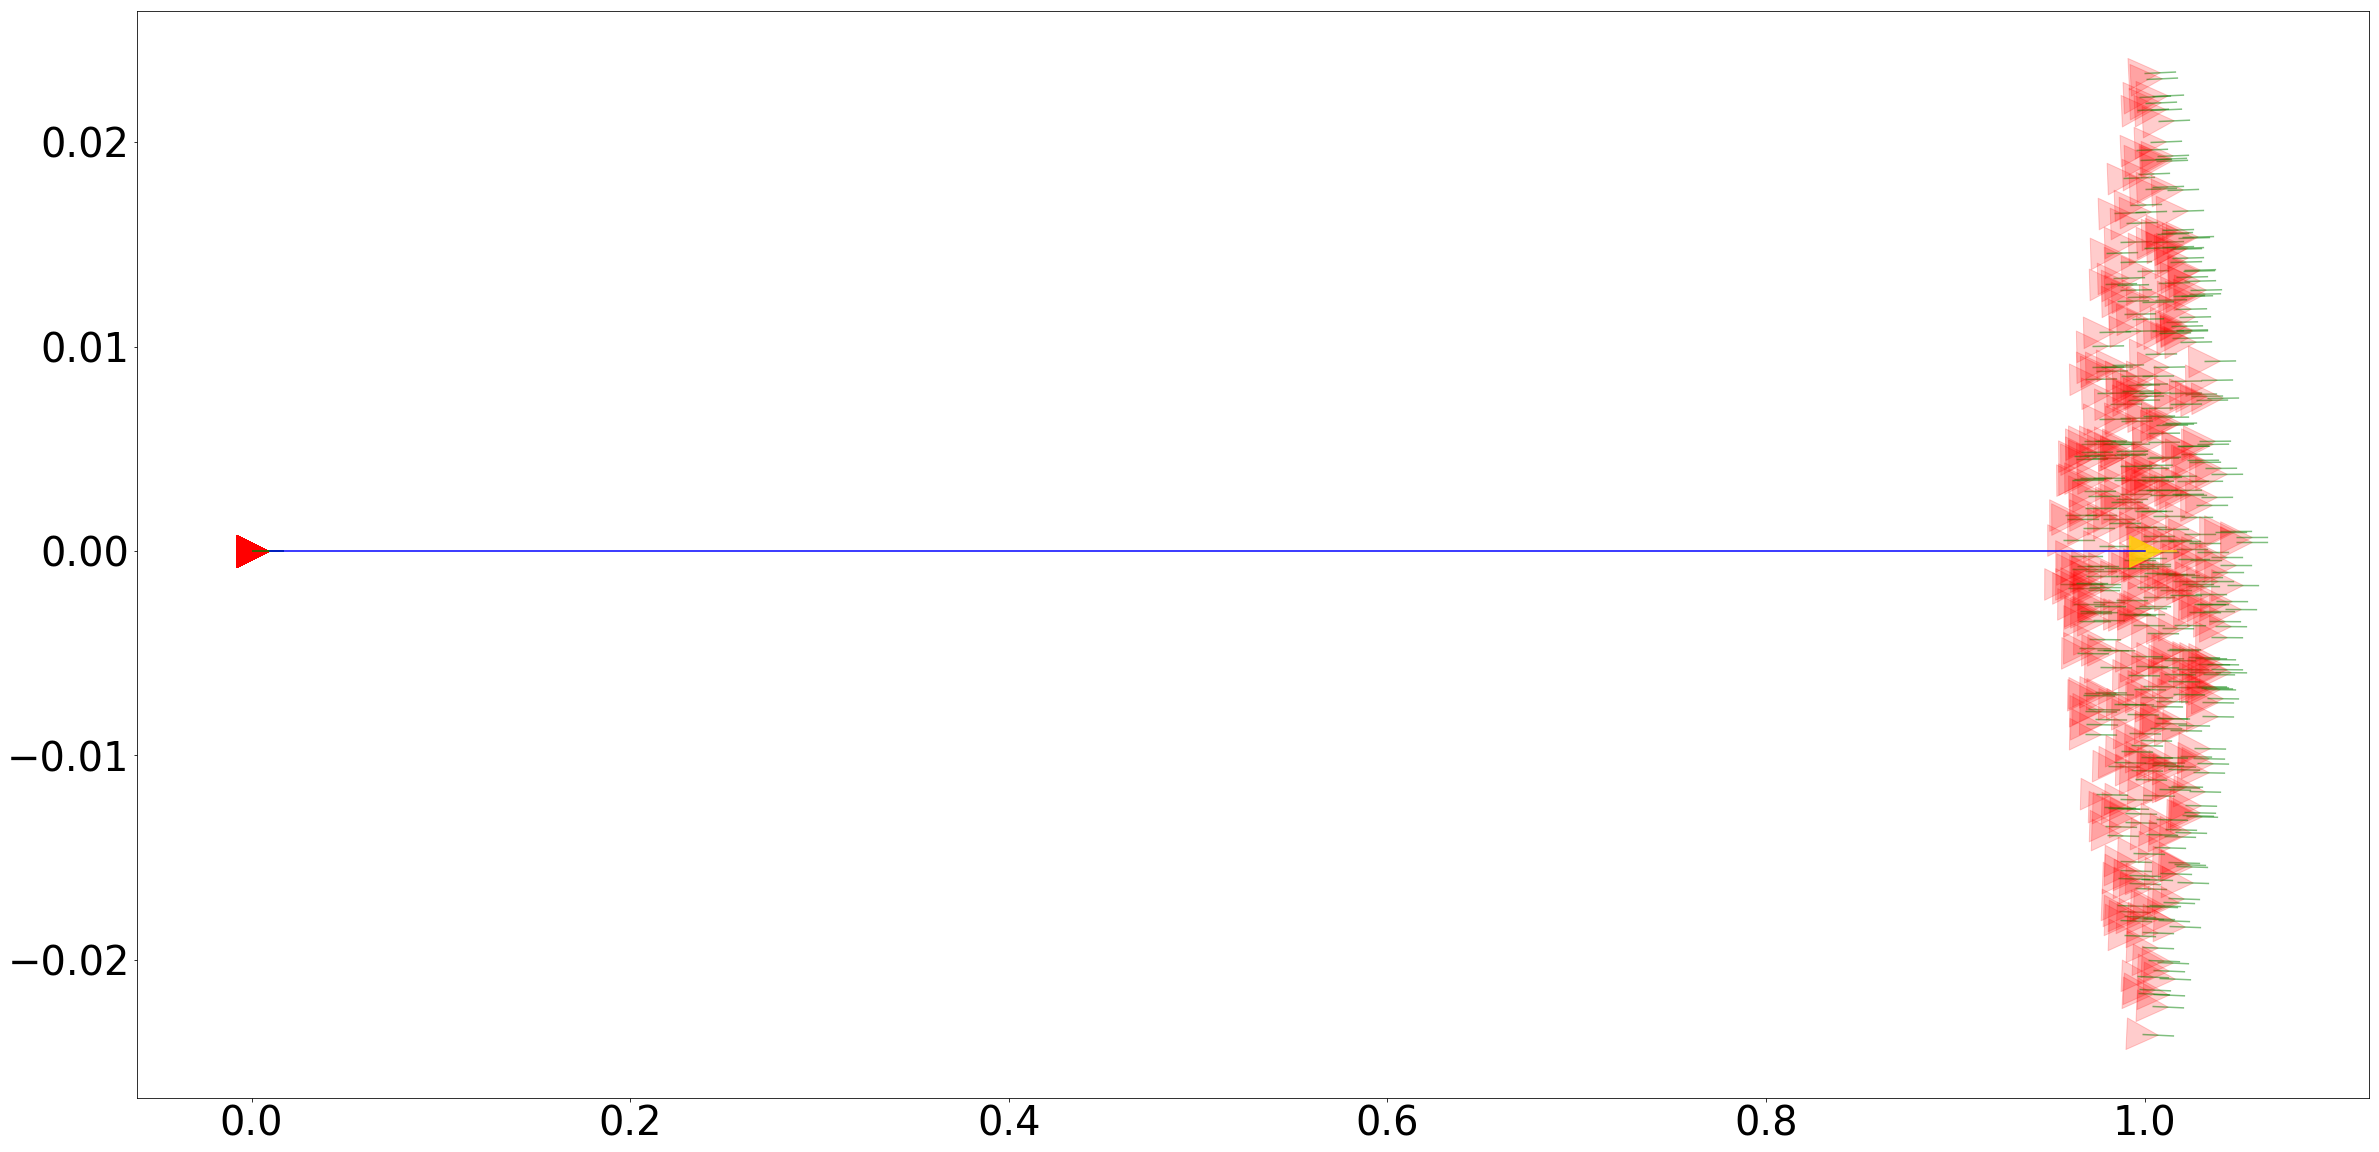

In [12]:
# now lets simulate some simple motion

# first generate samples_number samples in our initial starting pose
poses = [[start_pose]*samples_number]

# store history of the velocities in order to recreate the exact trajectory
vl_history, vr_history = [],[]

# lets move the robot forward 
vl, vr = 1, 1

# Save values
vl_history.append(vl)
vr_history.append(vr)

poses = update_samples(vl, vr, poses)

plt.figure(figsize=(40,20))

plot_all_estimates(poses)
exact_trajectory(vl_history,vr_history,start_pose)
plt.axis("normal")
plt.tick_params(labelsize=40)

Note that on the image above I am not using the equal axis scale, this is done just to show how the estimates are spread, and the actual shape of the robot, later I will use equal axis only!!!

Since the motions we are going to simulate are not going to be too trivial (i.e. robot will be changing the direction of its motion), I create the `simulate_motion` function that is going to simplify the code. It is crucial to: 
- accept the wheel velocities
- update the velocities history (for the TRUE path generation)
- have the poses and to update them (fortunately `update_samples` deals with update)
- also the time, denoting how long the robot moved under given velocities

In [13]:
# function simulate_motion simulates the motion of the robot given the velocities
# and the time under which the motion was performed

# function accepts:
# - velocities of wheels, 
# - histories of wheel motions (needed for the true path recreation!),
# - pose estimates of all steps, 
# - time (time of motion under this certain wheel velocities), NOTE ONLY INTs 
#     by default move 1 second

# it will return the newly generated poses, as well as the updated history list

def simulate_motion(vl, vr, vl_history, vr_history, poses, time = 1):
    for _ in range(time):
        vl_history.append(vl)
        vr_history.append(vr)

        poses = update_samples(vl, vr, poses)
    return vl_history, vr_history, poses

In [14]:
# Lets simulate some more interesting motion

# initialize samples_number of poses from the start pose
# poses actually also stores all the estimates that we have generated from all stages
poses = [[start_pose]*samples_number]

# store history in order to recreate the exact trajectory later
vl_history, vr_history = [],[]

# lets move the robot forward for 3 seconds
vl, vr = 1, 1
vl_history, vr_history, poses = simulate_motion(vl, vr, vl_history, vr_history, poses, time = 3)

# Then assume our robot starts turning left for 3 sec
vl, vr = 0.3, 1
vl_history, vr_history, poses = simulate_motion(vl, vr, vl_history, vr_history, poses, time = 3)

# Then assume our robot starts turning right for 3 sec
vl, vr = 1, 0.3
vl_history, vr_history, poses = simulate_motion(vl, vr, vl_history, vr_history, poses, time = 3)

# speed up the right turn for 3 sec
vl, vr = 2*2, 2*0.8
vl_history, vr_history, poses = simulate_motion(vl, vr, vl_history, vr_history, poses, time = 3)


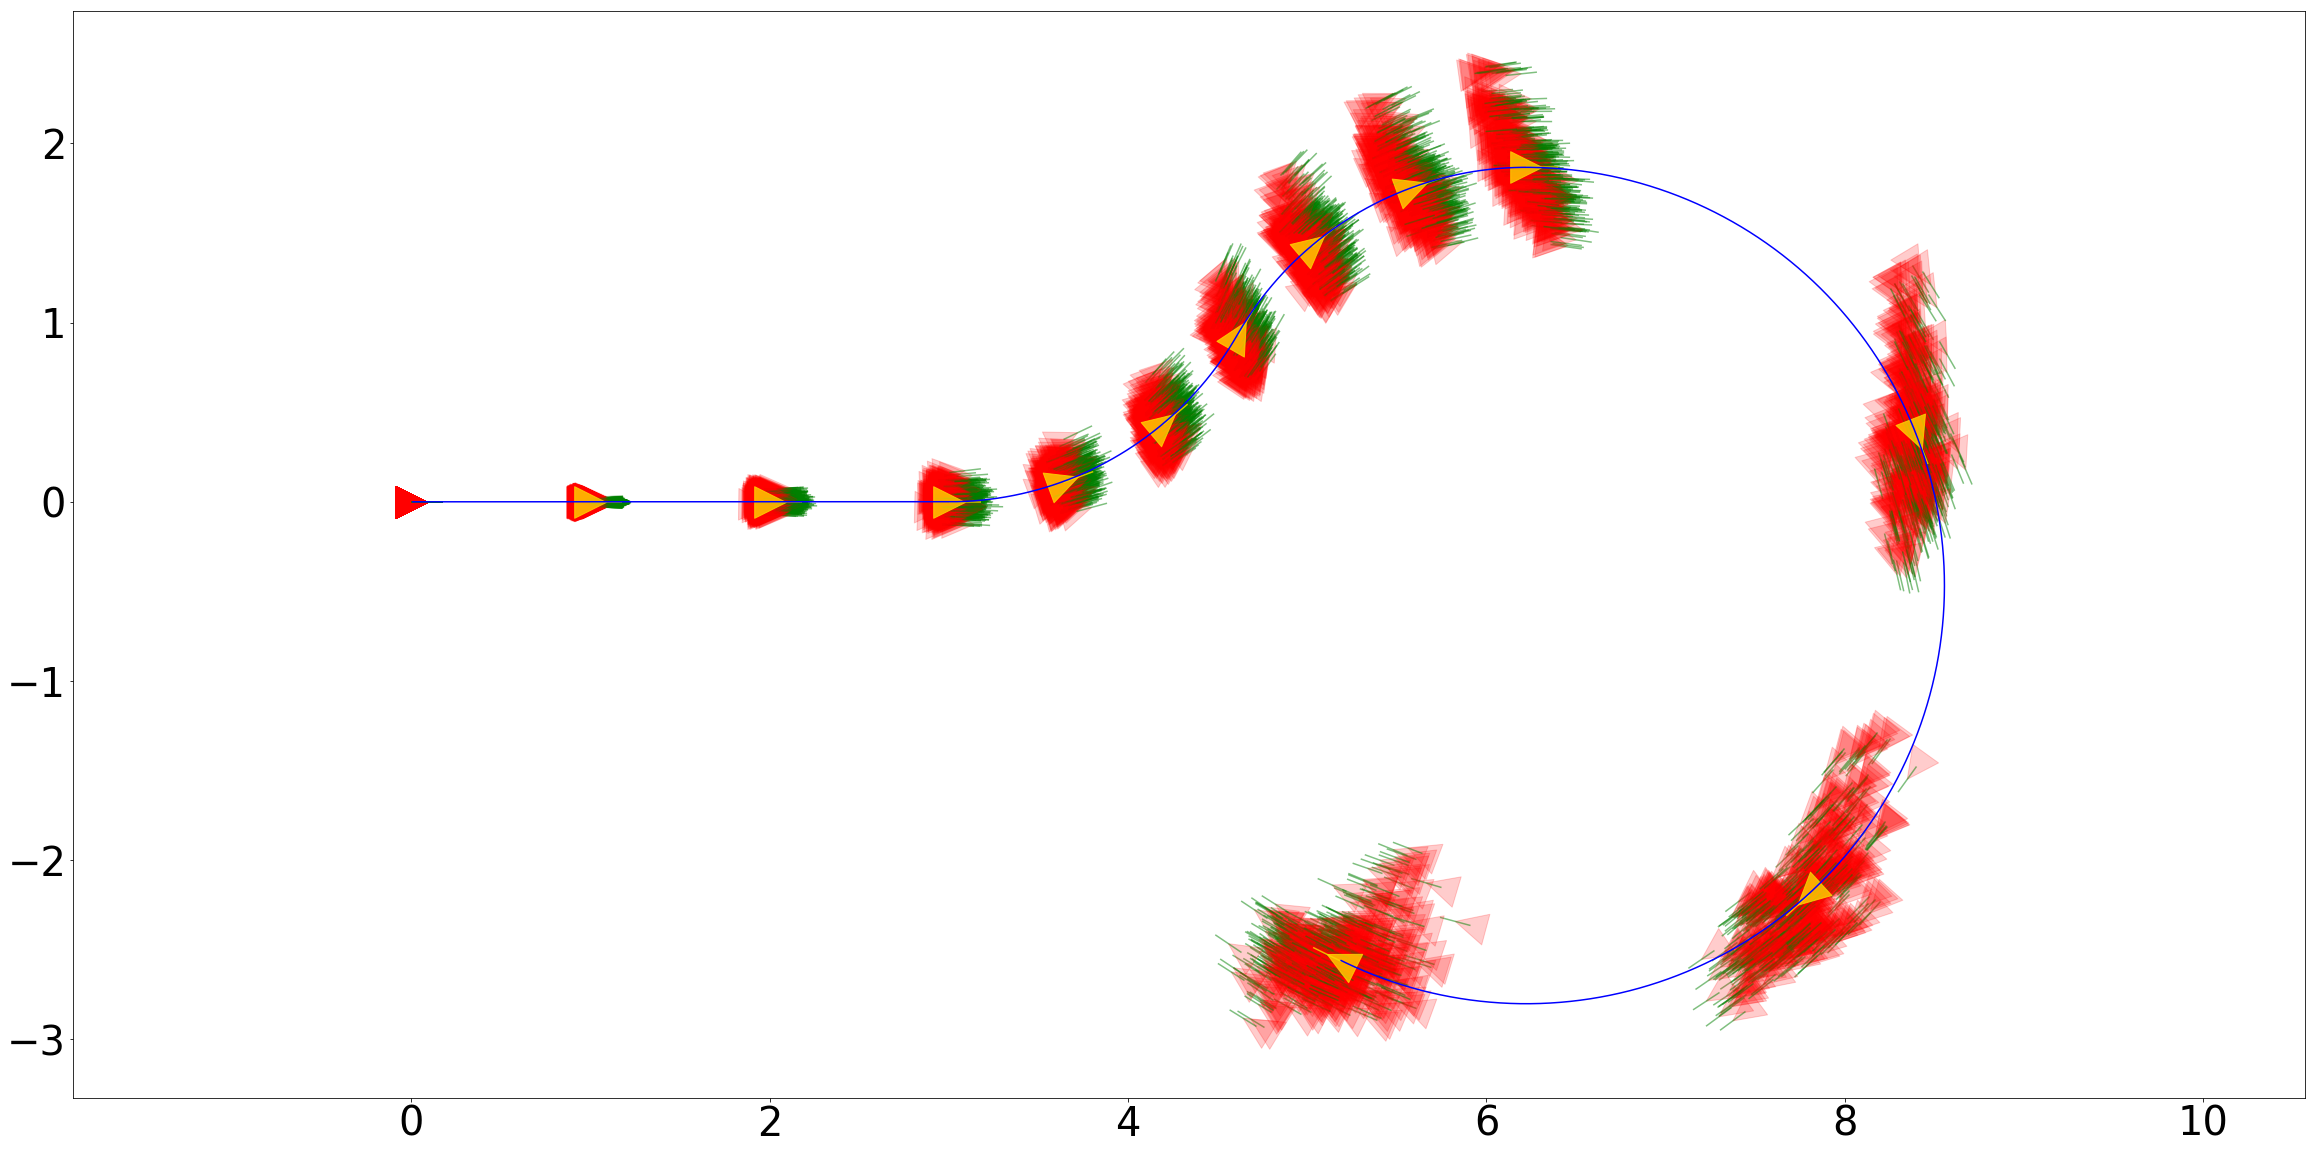

In [15]:
# Plot the motion

plt.figure(figsize=(40,20))

# increase the size of the graph
plot_all_estimates(poses)
exact_trajectory(vl_history,vr_history,start_pose)

plt.axis("equal")
plt.tick_params(labelsize=40)
plt.show()

### User Experiments

In [16]:
import ipywidgets

@ipywidgets.interact(samples_number = ipywidgets.IntSlider(min=10, max=600, value=100),
                     steps = ipywidgets.IntSlider(min=0, max=5, value=0),
                     vl=ipywidgets.FloatSlider(min=-2, max=+2),
                     vr=ipywidgets.FloatSlider(min=-2, max=+2))

def f(samples_number, steps, vl, vr):
    # Initialze start pose and the history of velocities
    poses = [[start_pose]*samples_number]
    vl_history, vr_history = [],[]
    
    vl_history, vr_history, poses = simulate_motion(vl, vr, vl_history, vr_history, poses, time = steps)

    # plotting part    
    plt.figure(figsize=(40,20))
    
    plot_all_estimates(poses)
    exact_trajectory(vl_history,vr_history,start_pose)
        
    plt.axis("equal")
    plt.tick_params(labelsize=40)

interactive(children=(IntSlider(value=100, description='samples_number', max=600, min=10), IntSlider(value=0, …

### Now lets see how the estimates change based on the different randomly generated values

 With my implementation of the samples and due to the specifics of `plt.scatter` it is much harder to use `matplotlib.animation` tool. Therefore, I found an implementation that is capable of taking the snapshots
 of the active plot/scene, so later we can easily visualize it! 
 
 To animate I use `celluloid`, if it's not installed please run the command below 
 (Just uncomment the line below if you don't have celluloid)

In [17]:
# !pip3 install celluloid

Run #: 1
Run #: 2
Run #: 3
Run #: 4
Run #: 5
Done with simulation all estimates generation


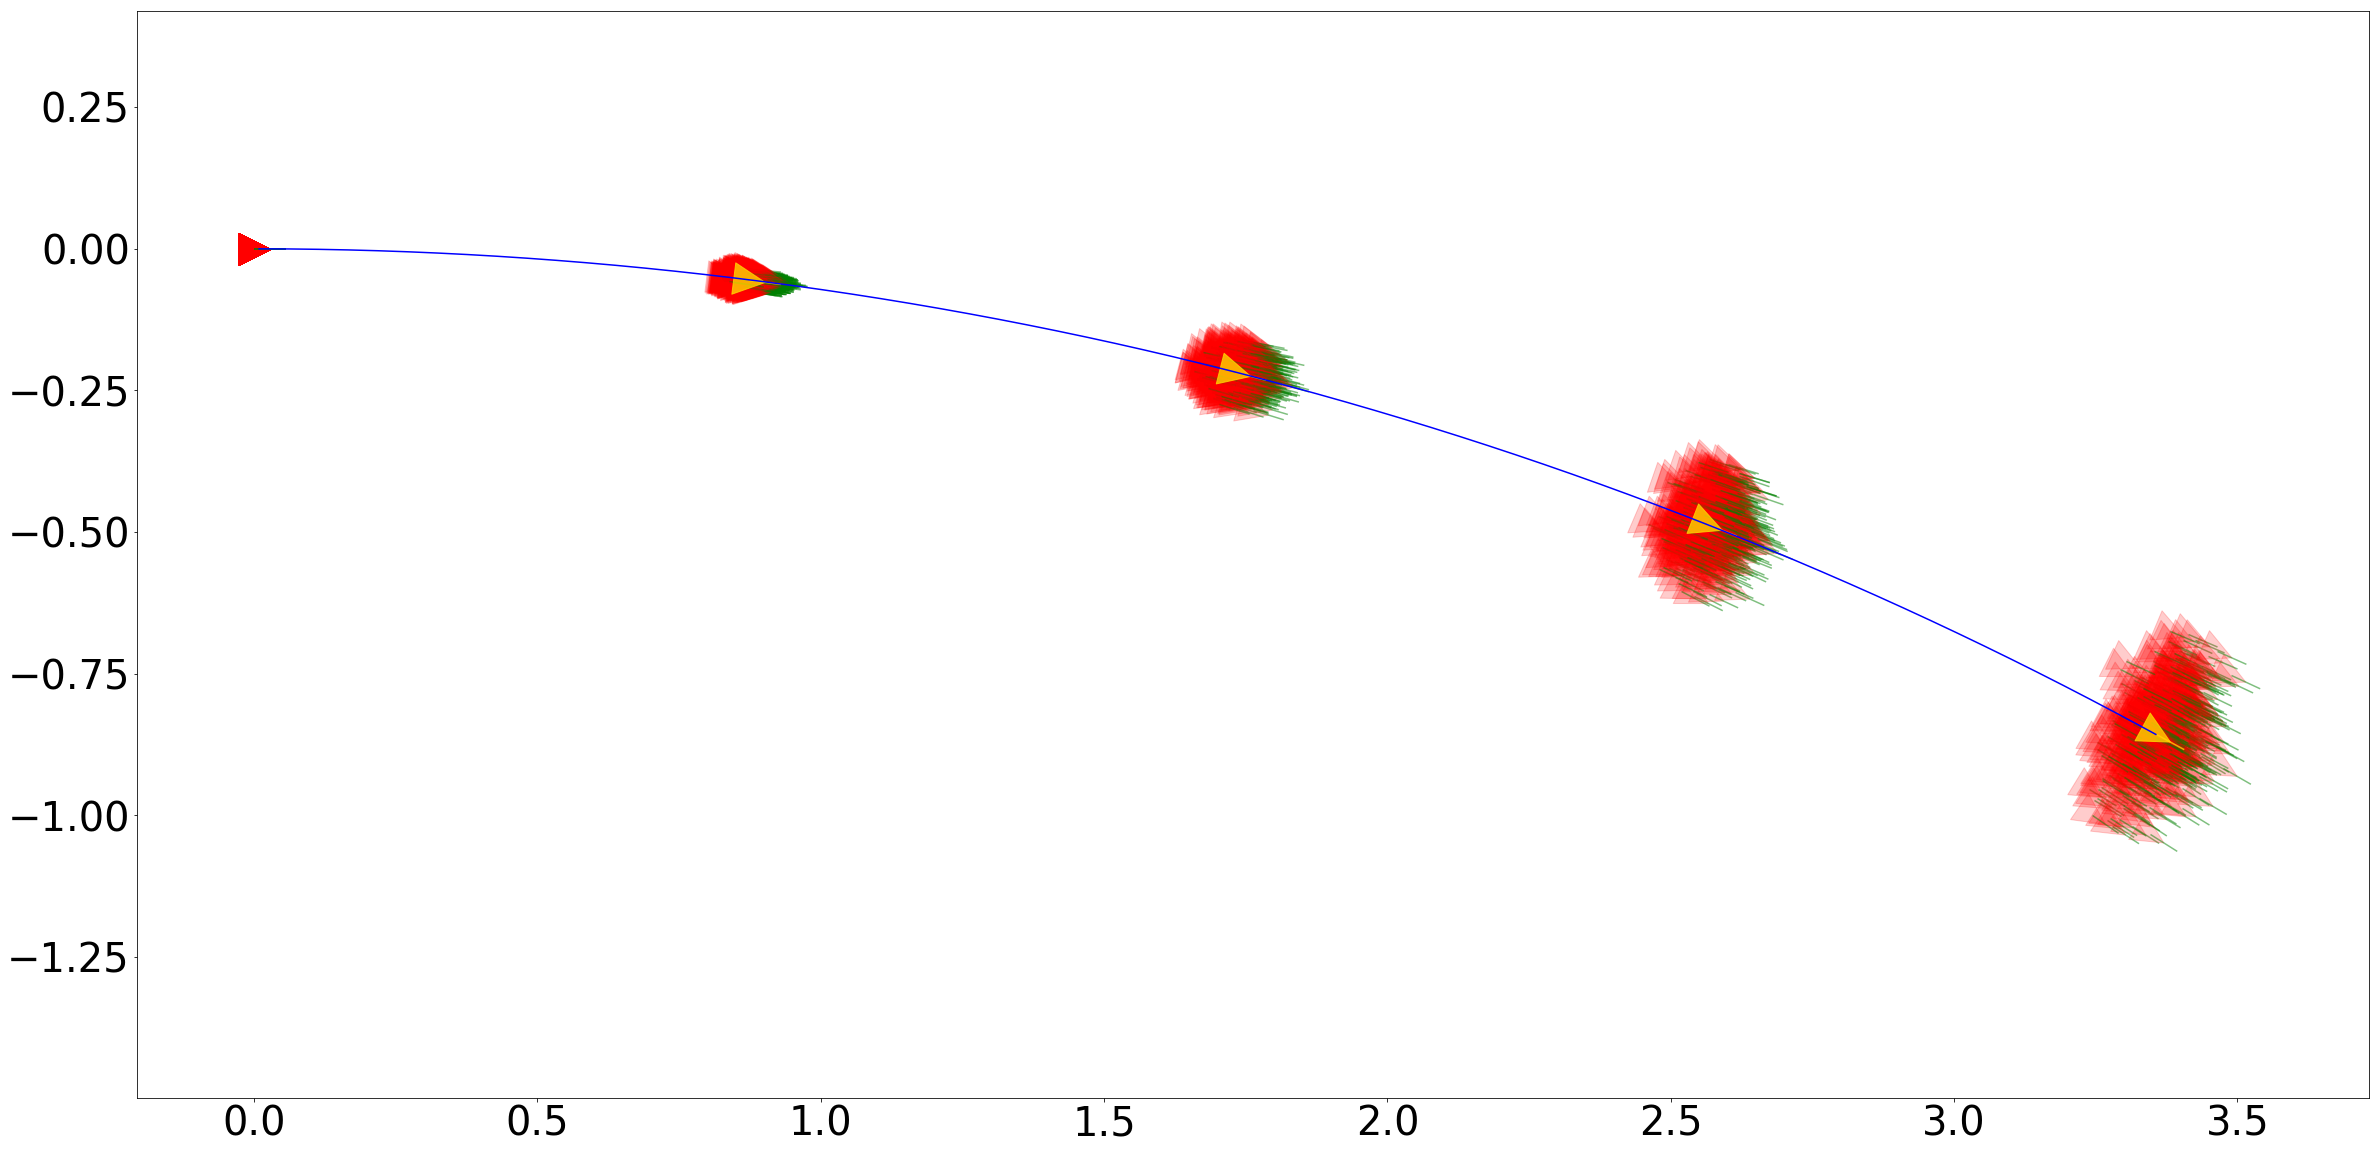

In [19]:
# This part of the code will take some time!

from matplotlib import animation, rc
from IPython.display import HTML
from matplotlib import cm
from celluloid import Camera


# Initialize figure
fig = plt.figure(figsize=(40,20))

# Initialize camera
camera = Camera(fig)

# how many times do we want to make random sampling on the same path
num_of_runs = 5

# for how many seconds do we let robot move
n_sec = 4


for i in range(num_of_runs):
    print ("Run #:", i+1)
    
    # Initialize start pose estimates
    poses = [[start_pose]*samples_number]

    # store history in order to recreate the exact trajectory later
    vl_history, vr_history = [],[]

    # lets move the robot forward 
    vl, vr = 1, 0.75
    
    # move the robot for t sec
    vl_history, vr_history, poses = simulate_motion(vl, vr, vl_history, vr_history, poses, time = n_sec)
        
    
    # Plot the motion
    plot_all_estimates(poses)
    exact_trajectory(vl_history,vr_history,start_pose)

    plt.axis("equal")
    plt.tick_params(labelsize=40)
    
    # take a snap of the obtained image
    camera.snap()

print ("Done with simulation all estimates generation")

anim = camera.animate(blit=True)
display(HTML(anim.to_jshtml()))